<a href="https://colab.research.google.com/github/RavinduKodithuwakku/suicide-thoughts-detection/blob/dev/Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [4]:
!pip install -qqq emoji fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 KB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [5]:
# Import packages
import os
import pandas as pd
import numpy as np
import itertools
import collections
import networkx as nx
import six
import matplotlib.pyplot as plt
import seaborn as sns
import emoji as em
import fasttext

from keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.model_selection import train_test_split

import nltk
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.corpus import stopwords
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
# Set constants
SEED = 4222

In [7]:
df = pd.read_csv('/content/drive/MyDrive/fyp/dataset/Suicide_Detection.csv', index_col=0)
df.reset_index(drop=True, inplace=True)
df.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [8]:
# Check for null values
df.isnull().sum()

text     0
class    0
dtype: int64

suicide        116037
non-suicide    116037
Name: class, dtype: int64
suicide        0.5
non-suicide    0.5
Name: class, dtype: float64


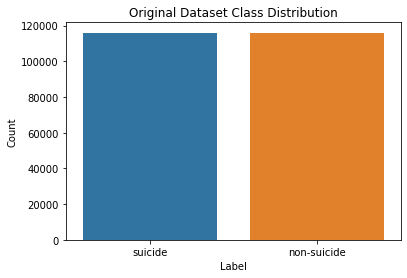

In [9]:
# Check class distribution
print(df['class'].value_counts())
print(df['class'].value_counts(normalize=True))

sns.countplot(x=df['class'])
plt.title('Original Dataset Class Distribution')
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [10]:
# Check lowercase
lowercase = df['text'].str.islower()
print(lowercase.value_counts())

False    214395
True      17679
Name: text, dtype: int64


In [11]:
# Check extra whitespace
extra_whitespace = df['text'].str.match('\s\s+')
print(extra_whitespace.value_counts())

False    232073
True          1
Name: text, dtype: int64


In [12]:
# Check URL
url = df['text'].str.contains("http")
print(url.value_counts())

False    224921
True       7153
Name: text, dtype: int64


In [13]:
# Check mentions
mention = df['text'].str.match('@(\w+)')
print(mention.value_counts())

False    232072
True          2
Name: text, dtype: int64


In [14]:
# Check hashtags
hashtag = df['text'].str.match('#(\w+)')
print(hashtag.value_counts())

False    232061
True         13
Name: text, dtype: int64


In [15]:
# Check subreddit tag
subreddit = df['text'].str.match('r/(\w+)')
print(subreddit.value_counts())

False    231990
True         84
Name: text, dtype: int64


In [16]:
# Check users tag
users = df['text'].str.match('u/(\w+)')
print(users.value_counts())

False    231859
True        215
Name: text, dtype: int64


In [17]:
# Check special characters
special_characters = df['text'].str.match('[^0-9a-zA-Z]+')
print(special_characters.value_counts())

False    229638
True       2436
Name: text, dtype: int64


In [18]:
! pip install emoji
import emoji


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
# Check emojis
def text_has_emoji(text):
    for character in text:
        if character in emoji.EMOJI_DATA:
            return True
    return False

emoji = df['text'].apply(text_has_emoji)
print(emoji.value_counts())

False    221956
True      10118
Name: text, dtype: int64


In [20]:
# Check language
!wget -O /tmp/lid.176.bin https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin

PRETRAINED_FASTTEXT_PATH = '/tmp/lid.176.bin'
model = fasttext.load_model(PRETRAINED_FASTTEXT_PATH)

def check_language(text):
  sentences = text.split("\n")
  predictions = model.predict(sentences)
  language = predictions[0][0][0].split("__label__")[1]
  confidence = predictions[1][0][0]

  return language

language = df['text'].apply(check_language)
print(language.value_counts())

--2023-02-04 16:45:02--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131266198 (125M) [application/octet-stream]
Saving to: ‘/tmp/lid.176.bin’

/tmp/lid.176.bin    100%[===================>] 125.18M  12.3MB/s    in 15s     

2023-02-04 16:45:18 (8.14 MB/s) - ‘/tmp/lid.176.bin’ saved [131266198/131266198]



en     229334
de        596
ca        362
ja        353
si        166
        ...  
te          1
jbo         1
tt          1
cy          1
bg          1
Name: text, Length: 90, dtype: int64


Cleaned dataset

In [21]:
clean_df = pd.read_csv('/content/drive/MyDrive/fyp/dataset/suicide_detection_final_cleaned.csv', header=0)
clean_df

,text,class,cleaned_text
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,sex wife threaten suicide recently leave wife ...
1,Am I weird I don't get affected by compliments...,non-suicide,weird not affect compliment come know girl fee...
2,Finally 2020 is almost over... So I can never ...,non-suicide,finally hear bad year swear fuck god annoying
3,i need helpjust help me im crying so hard,suicide,need help help cry hard
4,It ends tonight.I can’t do it anymore. \nI quit.,suicide,end tonight not anymore quit
...,...,...,...
175969,I did something today I went sledding with my ...,non-suicide,today go sled friend not like pretty big miles...
175970,If you don't like rock then your not going to ...,non-suicide,not like rock not go
175971,You how you can tell i have so many friends an...,non-suicide,tell friend not lonely deprive buy little nigh...
175972,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide,pee probably taste like salty tea drink pee co...


In [22]:
# Check for null values
clean_df.isnull().sum()

text              0
class             0
cleaned_text    148
dtype: int64

In [23]:
# Split dataset into train and test sets 
train_data, test_data = train_test_split(clean_df,
                                         test_size=0.2, 
                                         random_state=SEED,
                                         stratify=clean_df['class'])

In [24]:
# Split train set into classes
train_data_suicidal = train_data[train_data['class'] == "suicide"]
train_data_nonsuicidal = train_data[train_data['class'] == "non-suicide"]

non-suicide    107548
suicide         68426
Name: class, dtype: int64
non-suicide    0.611158
suicide        0.388842
Name: class, dtype: float64


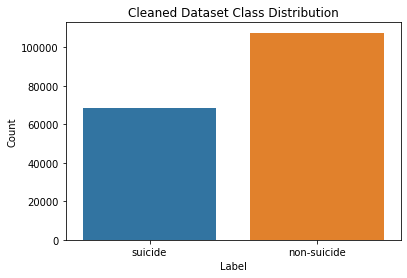

In [25]:
# Check class distribution
print(clean_df['class'].value_counts())
print(clean_df['class'].value_counts(normalize=True))

sns.countplot(x=clean_df['class'])
plt.title('Cleaned Dataset Class Distribution')
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

non-suicide    86038
suicide        54741
Name: class, dtype: int64
non-suicide    0.611156
suicide        0.388844
Name: class, dtype: float64


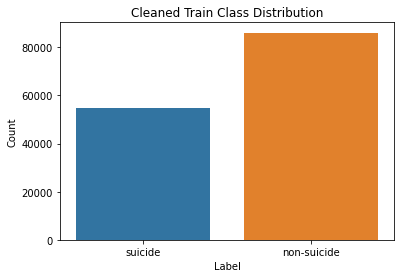

In [26]:
# Check class distribution
print(train_data['class'].value_counts())
print(train_data['class'].value_counts(normalize=True))

sns.countplot(x=train_data['class'])
plt.title('Cleaned Train Class Distribution')
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [27]:
train_data_suicidal.cleaned_text = train_data_suicidal.cleaned_text.astype(str)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data_suicidal['cleaned_text'])

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [28]:
tokenizer.word_counts.items()

odict_items([('feel', 30563), ('like', 24442), ('lose', 4548), ('wake', 2565), ('wonder', 1066), ('happen', 3774), ('die', 14565), ('today', 3874), ('buy', 889), ('paracetamol', 118), ('ibuprofen', 95), ('kill', 15126), ('think', 19130), ('use', 1038), ('stash', 12), ('vodka', 118), ('hide', 386), ('room', 892), ('note', 1483), ('say', 4351), ('drink', 1122), ('pill', 2142), ('get', 9596), ('life', 24347), ('track', 232), ('finally', 2309), ('want', 41183), ('end', 12014), ('not', 110289), ('trust', 656), ('family', 6954), ('overreact', 62), ('friend', 12322), ('take', 3823), ('piss', 247), ('thing', 10746), ('calm', 457), ('update', 214), ('recently', 1321), ('well', 7779), ('touch', 267), ('boyfriend', 1293), ('stop', 5981), ('jerk', 53), ('explain', 644), ('see', 1837), ('relieve', 116), ('lot', 2962), ('stress', 923), ('co', 113), ('worker', 111), ('job', 3762), ('week', 3522), ('relief', 294), ('talk', 8671), ('therapist', 1255), ('asperger', 78), ('self', 2810), ('disclosure', 7)

In [29]:
word_freq_suicidal = pd.DataFrame(tokenizer.word_counts.items(), columns=['word','count']).sort_values(by='count', ascending=False)

Word Frequency Bar Graph

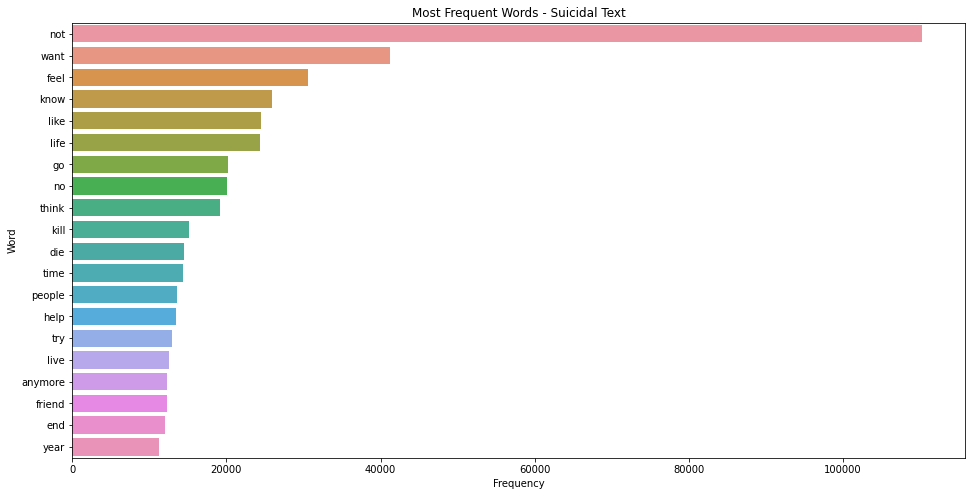

In [30]:
# Word Frequency Bar Graph
plt.figure(figsize=(16, 8))
sns.barplot(x='count',y='word',data=word_freq_suicidal.iloc[:20])
plt.title('Most Frequent Words - Suicidal Text')
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

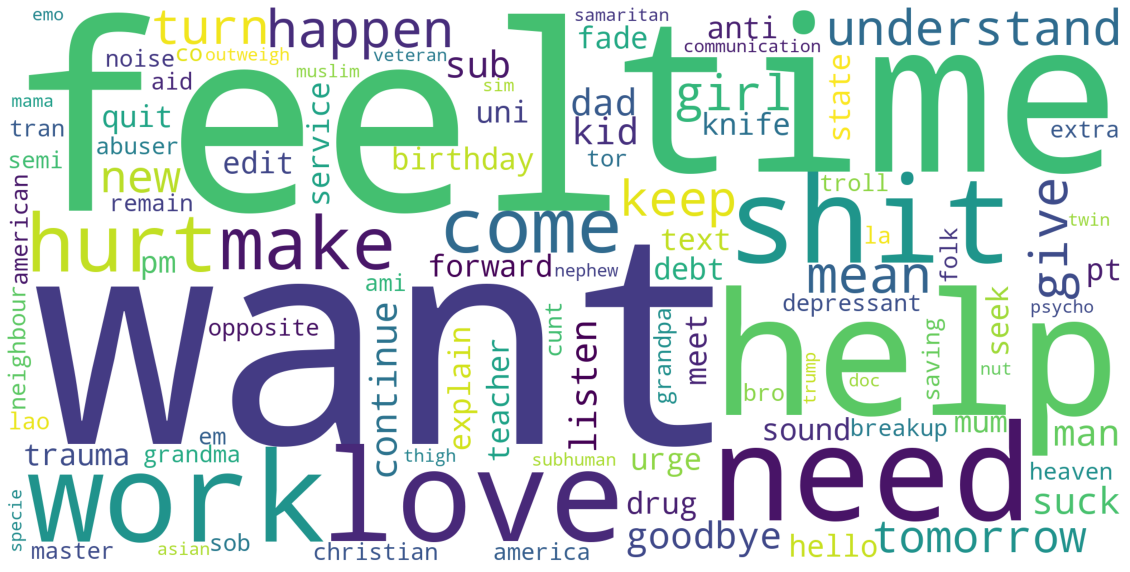

In [31]:
# Wordcloud 
feature_names=word_freq_suicidal['word'].values
wc=WordCloud(max_words=100, background_color="white", width=2000, height=1000)
wc.generate(' '.join(word for word in feature_names))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)
plt.show()


Distribution of Text Length

In [32]:
# Get average text length
train_data_suicidal['cleaned_text'] = train_data_suicidal['cleaned_text'].astype('str')
train_data_suicidal['length'] = train_data_suicidal['cleaned_text'].apply(lambda x: len(x.split()))


<ipython-input-32-0f87be20d31e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_suicidal['cleaned_text'] = train_data_suicidal['cleaned_text'].astype('str')
<ipython-input-32-0f87be20d31e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_suicidal['length'] = train_data_suicidal['cleaned_text'].apply(lambda x: len(x.split()))


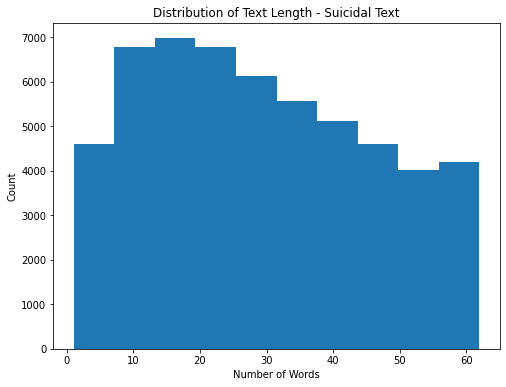

In [33]:
# Plot average text length
ax = train_data_suicidal['length'].plot(kind='hist',title='Distribution of Text Length - Suicidal Text', figsize=(8,6))
ax.set_xlabel("Number of Words")
ax.set_ylabel("Count")
plt.show()

Polarity Score Distribution

In [34]:
# Polarity score distribution
def get_polarity(text):
  return TextBlob(text).sentiment.polarity
train_data_suicidal['Polarity'] = train_data_suicidal['cleaned_text'].apply(get_polarity)

<ipython-input-34-e74fee14156f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_suicidal['Polarity'] = train_data_suicidal['cleaned_text'].apply(get_polarity)


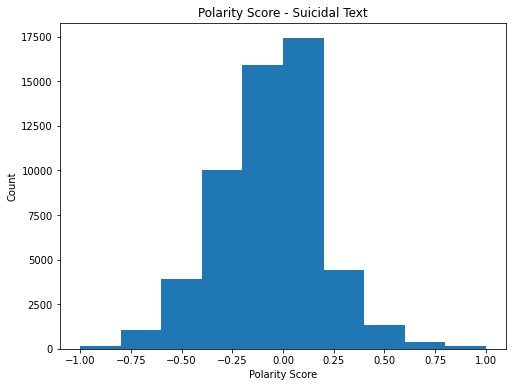

In [35]:
# Plot polarity score graph
ax = train_data_suicidal['Polarity'].plot(kind='hist', title='Polarity Score - Suicidal Text', figsize=(8,6))
ax.set_xlabel("Polarity Score")
ax.set_ylabel("Count")
plt.show()

In [36]:
!pip install nltk==3.6.2
#import nltk
#import sklearn

print('The nltk version is {}.'.format(nltk.__version__))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.3 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7


The nltk version is 3.7.


In [37]:
#Remove more stop words and do bigram
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')
train_data_suicidal['without_stopwords'] = train_data_suicidal['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

from nltk import bigrams
sentences = [text.split() for text in train_data_suicidal['without_stopwords']]

# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(text)) for text in sentences]

# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

#Create a table of the top 20 most paired words
bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['Bigram', 'Count'])

bigram_df    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-37-23baa8cef54a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_suicidal['without_stopwords'] = train_data_suicidal['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


,Bigram,Count
0,"(feel, like)",10713
1,"(want, die)",5607
2,"(want, kill)",2409
3,"(want, end)",1947
4,"(commit, suicide)",1708
5,"(want, live)",1668
6,"(suicidal, thought)",1621
7,"(need, help)",1514
8,"(end, life)",1462
9,"(year, old)",1321


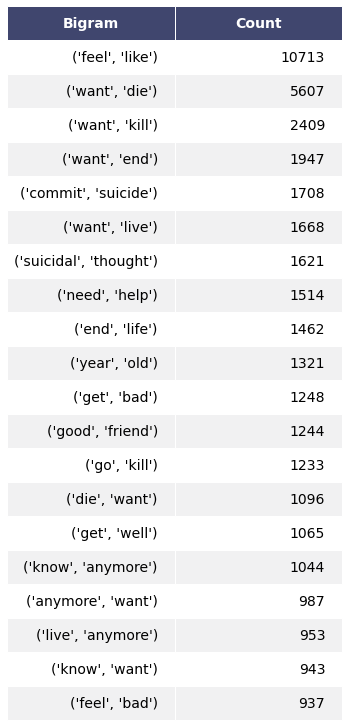

In [38]:
#To make the table nicer
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

render_mpl_table(bigram_df, header_columns=0, col_width=3)

Non-suicidal Text

In [39]:
tokenizer_nonsuicidal = Tokenizer()
tokenizer_nonsuicidal.fit_on_texts(train_data_nonsuicidal["text"])

In [40]:
tokenizer_nonsuicidal.word_counts.items()

odict_items([('guys', 6509), ('im', 7260), ('feeling', 1805), ('very', 3055), ('bad', 3756), ('pls', 1015), ('help', 6231), ('she', 10339), ('was', 18503), ('lowkey', 126), ('showing', 176), ('liked', 722), ('maybe', 1801), ('so', 30094), ('that', 30180), ('i', 149175), ('dont', 3027), ('feel', 7495), ('but', 28189), ('found', 1660), ('out', 11402), ('has', 5314), ('a', 80648), ('boyfriend', 681), ('lied', 94), ('bout', 121), ('him', 4371), ('blocked', 254), ('the', 74810), ('fuck', 4731), ('outta', 73), ('her', 9495), ('my', 56391), ('theory', 121), ('on', 23091), ('how', 12231), ('many', 1979), ('teenagers', 1610), ('including', 148), ('me', 37892), ('are', 16208), ('in', 32602), ('fact', 975), ('peter', 24), ('parker', 6), ('1', 3157), ('we', 11038), ('both', 1113), ('misunderstood', 12), ('geniuses', 4), ('with', 18905), ('lack', 126), ('of', 38748), ('common', 246), ('sense', 500), ('2', 4444), ('suffer', 102), ('from', 7132), ('female', 533), ('deficiency', 4), ("i'll", 1849), ('

In [41]:
word_freq_nonsuicidal = pd.DataFrame(tokenizer_nonsuicidal.word_counts.items(), columns=['word','count']).sort_values(by='count', ascending=False)
word_freq_nonsuicidal.head()

,word,count
15,i,149175
66,to,89703
85,and,87703
22,a,80648
28,the,74810


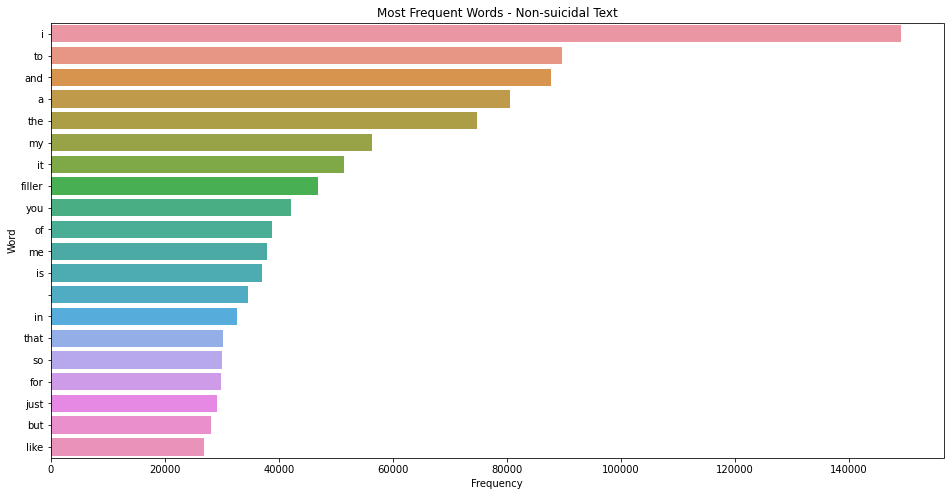

In [42]:
# Word Frequency Bar Graph
plt.figure(figsize=(16, 8))
sns.barplot(x='count', y='word', data=word_freq_nonsuicidal.iloc[:20])
plt.title('Most Frequent Words - Non-suicidal Text')
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

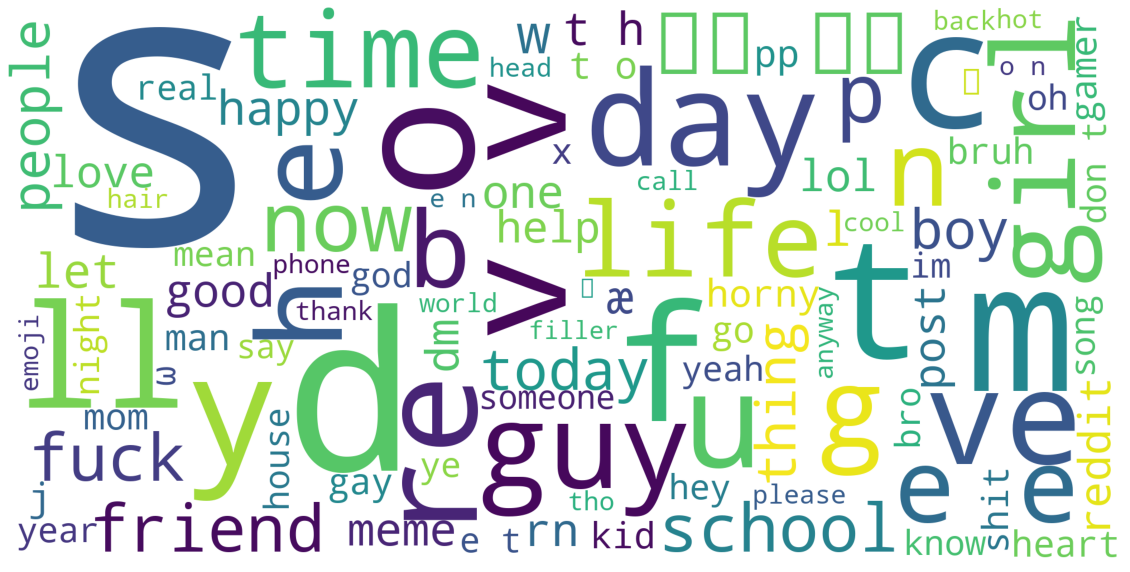

In [43]:
# Wordcloud  
feature_names_nonsuicidal = word_freq_nonsuicidal['word'].values
wc = WordCloud(max_words=100, background_color="white", width=2000, height=1000)
wc.generate(' '.join(word for word in feature_names_nonsuicidal))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)
plt.show()

Distribution of Text Length

In [44]:
# Get average text length
train_data_nonsuicidal['cleaned_text'] = train_data_nonsuicidal['cleaned_text'].astype('str')
train_data_nonsuicidal['length'] = train_data_nonsuicidal['cleaned_text'].apply(lambda x: len(x.split()))

<ipython-input-44-542edca4a36f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_nonsuicidal['cleaned_text'] = train_data_nonsuicidal['cleaned_text'].astype('str')
<ipython-input-44-542edca4a36f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_nonsuicidal['length'] = train_data_nonsuicidal['cleaned_text'].apply(lambda x: len(x.split()))


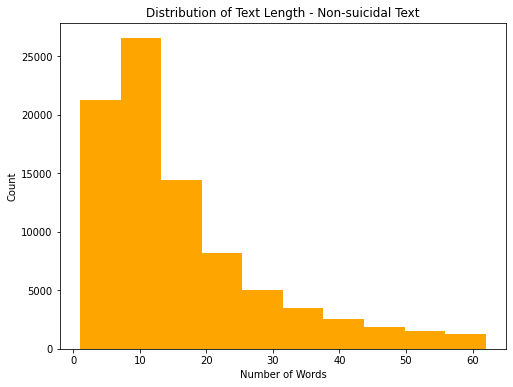

In [45]:
# Plot distribution of text length
ax = train_data_nonsuicidal['length'].plot(kind='hist',title='Distribution of Text Length - Non-suicidal Text', color='orange', figsize=(8,6))
ax.set_xlabel("Number of Words")
ax.set_ylabel("Count")
plt.show()

In [46]:
# Polarity score distribution
train_data_nonsuicidal['cleaned_text'] = train_data_nonsuicidal['cleaned_text'].astype('str')
train_data_nonsuicidal['Polarity'] = train_data_nonsuicidal['cleaned_text'].apply(get_polarity)

<ipython-input-46-26a0657c53be>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_nonsuicidal['cleaned_text'] = train_data_nonsuicidal['cleaned_text'].astype('str')
<ipython-input-46-26a0657c53be>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_nonsuicidal['Polarity'] = train_data_nonsuicidal['cleaned_text'].apply(get_polarity)


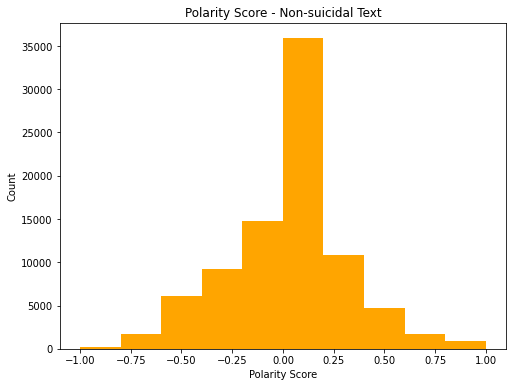

In [47]:
# Plot polarity score graph
ax = train_data_nonsuicidal['Polarity'].plot(kind='hist', title='Polarity Score - Non-suicidal Text', color="orange", figsize=(8,6))
ax.set_xlabel("Polarity Score")
ax.set_ylabel("Count")
plt.show()

Bigram

<ipython-input-48-7b9d6c52581e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_nonsuicidal['without_stopwords'] = train_data_nonsuicidal['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


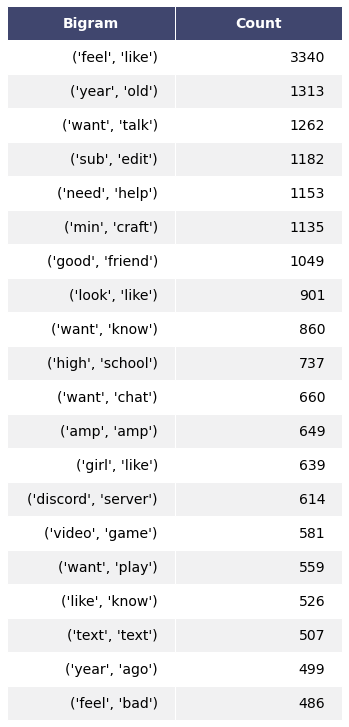

In [48]:
#Remove more stop words and do bigram
stop_words = stopwords.words('english')
train_data_nonsuicidal['without_stopwords'] = train_data_nonsuicidal['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

from nltk import bigrams
sentences = [text.split() for text in train_data_nonsuicidal['without_stopwords']]

# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(text)) for text in sentences]

# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

#Create a table of the top 20 most paired words
bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['Bigram', 'Count'])

render_mpl_table(bigram_df, header_columns=0, col_width=3)